## Auto ML

In [1]:
import pandas as pd
#from autogluon.tabular import TabularDataset, TabularPredictor
import utils.eda_utils as eda_utils 

In [11]:
train_df = pd.read_csv('data/240907_Rockhead_Seoul_train(false, before_aumentation).csv')
val_df = pd.read_csv('data/240907_Rockhead_Seoul_val(false, before_aumentation).csv')
test_df = pd.read_csv('data/240907_Rockhead_Seoul_test(false, before_aumentation).csv')

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(14657, 8)
(1628, 8)
(4074, 8)


/var/folders/jm/y3p2nc3142sgnvz8slzmdrdc0000gq/T/ipykernel_45764/1514360445.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_concat = pd.concat([df_concat, test_df, train_df, val_df])


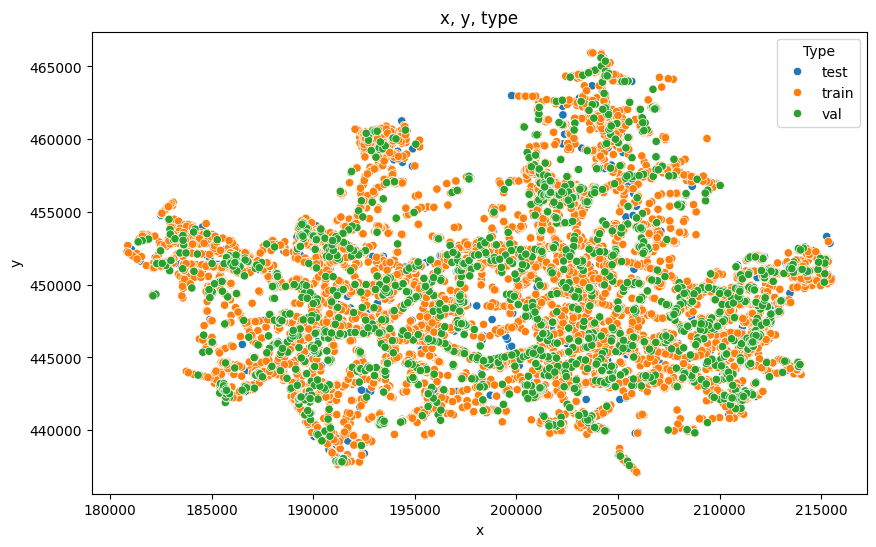

In [12]:
train_df['Type'] = 'train'
val_df['Type'] = 'val'
test_df['Type'] = 'test'

df_concat = pd.DataFrame(columns=train_df.columns)
df_concat = pd.concat([df_concat, test_df, train_df, val_df])

eda_utils.scatter_relation(df_concat, 'x', 'y', 'x, y, type','Type')

In [ ]:
# replace

def df_cleansing(df):

    # delete
    df = df.drop('depth_end', axis=1)
    df = df.drop('borehole_code', axis=1)

    # replace
    ground_name_map = {'WR':0, 'SR': 1, 'MR': 2, 'HR': 3}
    df['Ground name'] = df['Ground name'].map(ground_name_map)

    # normalize
    x_mean, x_std = df['x'].mean(), df['x'].std()
    y_mean, y_std = df['y'].mean(), df['y'].std()
    elevation_mean, elevation_std = df['elevation'].mean(), df['elevation'].std()
    density_mean, density_std = df['Density'].mean(), df['Density'].std()

    df['x'] = (df['x']-x_mean)/x_std
    df['y'] = (df['y']-y_mean)/y_std
    df['elevation'] = (df['elevation']-elevation_mean)/elevation_std
    df['Density'] = (df['Density']-density_mean)/density_std

    return df

In [ ]:
train_df = df_cleansing(train_df)
val_df = df_cleansing(val_df)
test_df = df_cleansing(test_df)

In [3]:
train = TabularDataset(train_df)
val = TabularDataset(val_df)
test = TabularDataset(test_df.drop(['depth_start'], axis=1))

In [4]:
hyperparameter_tune_kwargs = {  
    'num_trials': 45,
    'scheduler' : 'local',
    'searcher': 'auto',
}

predictor = TabularPredictor(label='depth_start', 
                             problem_type = 'regression', 
                             eval_metric='r2',
                             verbosity =2
                             )

predictor.fit(train, time_limit = 36000, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,  presets="good_quality", save_space = True, keep_only_best = True, save_bag_folds = False )

2024-08-22 19:28:32,667	INFO timeout.py:54 -- Reached timeout of 1788.010520672798 seconds. Stopping all trials.
2024-08-22 19:28:32,692	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-08-22 19:28:32,700	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to 'D:/rockhead_prediction/AutogluonModels/ag-20240822_024244/models/NeuralNetTorch_BAG_L2' in 0.0300s.
2024-08-22 19:28:36,891	WARNING experiment_analysis.py:190 -- Failed to fetch metric

In [5]:
ld_board = predictor.leaderboard(train, silent=True)

ld_board

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetFastAI_BAG_L2\c8a46a45_FULL,0.960796,None,r2,377.690712,NaN,3380.934790,0.388068,NaN,26.192592,2,True,210
1,WeightedEnsemble_L3_FULL,0.958633,None,r2,380.961286,NaN,3723.327314,0.014503,NaN,0.229040,3,True,217
2,NeuralNetFastAI_BAG_L2\58603ec4_FULL,0.957062,None,r2,377.676710,NaN,3381.197835,0.374066,NaN,26.455637,2,True,211
3,XGBoost_BAG_L1\T1_FULL,0.956002,None,r2,0.324056,NaN,1.475259,0.324056,NaN,1.475259,1,True,144
4,XGBoost_BAG_L1\T35_FULL,0.955087,None,r2,0.156028,NaN,0.953167,0.156028,NaN,0.953167,1,True,178
...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,NeuralNetFastAI_BAG_L1\c05a9ddb_FULL,-0.043074,None,r2,0.196035,NaN,12.282654,0.196035,NaN,12.282654,1,True,120
213,NeuralNetFastAI_BAG_L1\386dad00_FULL,-0.116359,None,r2,0.120520,NaN,4.414775,0.120520,NaN,4.414775,1,True,103
214,NeuralNetFastAI_BAG_L1\f8dbdb4f_FULL,-1.396029,None,r2,0.091517,NaN,1.200210,0.091517,NaN,1.200210,1,True,118
215,NeuralNetTorch_BAG_L1\2036e156_FULL,-2.184535,None,r2,0.080014,NaN,15.539724,0.080014,NaN,15.539724,1,True,197


In [6]:
pred_y = predictor.predict(test)

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error, r2_score
import numpy as np

y_test = test_df['depth_start'].values.tolist()

mae = mean_absolute_error(y_test, pred_y)
mse = mean_squared_error(y_test, pred_y)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred_y)

print('mae: ',mae)
print('mse: ',mse)
print('rmse: ',rmse)
print('r2: ',r2) #1에 가까울수록 좋음

mae:  2.133604361394134
mse:  9.339018166844426
rmse:  3.0559807209543104
r2:  0.8151711407458888
